In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import implicit
import scipy.sparse as sparse
from sklearn.model_selection import ParameterGrid
import os
import time

#Recommended for implicit
os.environ["MKL_NUM_THREADS"] = "1"

In [118]:
plt.rc('font', family = "serif")
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [2]:
def constructCodes(df) :
    """
    Maps 'steamid' to categorical code 'sid'
    Maps 'appid' to categorical code 'aid'
    Returns :
        1. Dataframe with columns 'sid', 'aid', 'playtime_forever'
        2. Dictionary mapping 'steamid' to 'sid'
        3. Dictionary mapping 'sid' to 'steamid'
        4. Dictionary mapping 'appid' to 'aid'
        5. Dictionary mapping 'aid' to 'appid'
    """
    coded_df = df.copy(deep = True)
    coded_df["steamid"] = coded_df["steamid"].astype("category")
    coded_df["appid"] = coded_df["appid"].astype("category")
    coded_df["sid"] = coded_df["steamid"].cat.codes
    coded_df["aid"] = coded_df["appid"].cat.codes
    
    sid_to_steamid = dict(enumerate(coded_df["steamid"].cat.categories))
    aid_to_appid = dict(enumerate(coded_df["appid"].cat.categories))
    steamid_to_sid = {v : k for k, v in sid_to_steamid.items()}
    appid_to_aid = {v : k for k, v in aid_to_appid.items()}
    
    coded_df.drop(["steamid", "appid"], axis = 1, inplace = True)
    
    return(coded_df, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid)

In [3]:
def getSplit(df, train_size, validation_size) :
    """
    Returns Train, Validation and Test DataFrames
    """
    train = df.copy(deep = True)
    val = df.copy(deep = True)
    test = df.copy(deep = True)
    
    assert train_size + validation_size < 1, "train_size + validation_size should be less than 1"
    test_size = 1 - train_size - validation_size
    
    test_sample = df.groupby("sid").apply(lambda x : x.sample(frac = test_size))
    test_sample.reset_index(level = 0, drop = True, inplace = True)
    test_idx = test_sample.index
    train.drop(test_idx, inplace = True)
    val.drop(test_idx, inplace = True)
    
    val_sample = train.groupby("sid").apply(lambda x : x.sample(frac = validation_size / (1 - test_size)))
    val_sample.reset_index(level = 0, drop = True, inplace = True)
    val_idx = val_sample.index
    train.drop(val_idx, inplace = True)
    
    assert train["sid"].nunique() == df["sid"].nunique()
    assert val["sid"].nunique() == df["sid"].nunique()

    #Contingency if any appids don't make it to train and val
    if train["aid"].nunique() != df["aid"].nunique() :
        missing_train_aid = list(set(df["aid"].unique()) - set(train["aid"].unique()))
        train_append = []
        for aid in missing_train_aid :
            train_append.append([0, 0, aid])
        train = train.append(pd.DataFrame(train_append, columns = ["playtime_forever", "sid", "aid"]), ignore_index = True)
    
    if val["aid"].nunique() != df["aid"].nunique() :
        missing_val_aid = list(set(df["aid"].unique()) - set(val["aid"].unique()))
        val_append = []
        for aid in missing_val_aid :
            val_append.append([0, 0, aid])
        val = val.append(pd.DataFrame(val_append, columns = ["playtime_forever", "sid", "aid"]), ignore_index = True)  
    
    return(train, val, test)

In [4]:
def constructSparseMatrices(df) :
    """
    Constructs sparse matrices that will be used in ALS optimization
    Input : Dataframe with columns - 'sid', 'aid', 'playtime_forever'
    
    Returns :
        1. User x Item Sparse Matrix
        2. Item x User Sparse Matrix
    """
    data_useritem = sparse.csr_matrix((df["playtime_forever"], (df["sid"], df["aid"])))
    data_itemuser = sparse.csr_matrix((df["playtime_forever"], (df["aid"], df["sid"])))
    
    sid_unique = df["sid"].nunique()
    aid_unique = df["aid"].nunique()
    
    assert data_useritem.shape == (sid_unique, aid_unique)
    assert data_itemuser.shape == (aid_unique, sid_unique)
    
    return(data_useritem, data_itemuser)

In [127]:
def trainModel(data, factors, epochs, conf_func, alpha, lmbda) :
    """
    Builds and trains Implicit Matrix Factorization model.
    Input :
        1. data - Item x User Sparse Matrix
        2. factors - Number of latent factors
        3. epochs - Number of iterations of ALS over the training data
        4. conf_func - Confidence function
        5. alpha - Confidence parameter
        6. lmbda - Regularization parameter
        
    Output : model
    """
    model = implicit.als.AlternatingLeastSquares(factors = factors, regularization = lmbda, iterations = epochs)
    if conf_func == "linear" :
        model.fit(alpha * data, show_progress = False)
    elif conf_func == "log" :
        epsilon = 1
        data.data = np.log(1 + data.data / epsilon)
        model.fit(alpha * data, show_progress= False)
    else :
        print("{} is not a valid choice for conf_func. Choose one of the following : 'linear', 'log'".format(conf_func))
        return(None)
    return(model)

In [6]:
def getMaskedAid(sid, df1, df2) :
    """
    Returns the masked aid's for input sid
    Expects df2 to be the bigger dataframe (For example, df1 = Train, df2 = Test is valid but the opposite is not)
    """
    df1_aid = set(df1[df1["sid"] == sid]["aid"].values)
    df2_aid = set(df2[df2["sid"] == sid]["aid"].values)
    masked_aid = list(df2_aid - df1_aid)
    full_aid = list(df2_aid)
    assert len(masked_aid) != 0

    return(masked_aid, full_aid)

In [7]:
def getPrecisionRecall(model, sid, N, train, test, data_useritem) :
    """
    Returns the precision@N and recall@N for given userid : 'sid'
    Input :
        1. model - Implicit Matrix Factorization trained model
        2. sid - User id whose precision and recall is to be calculated
        3. N - N parameter in precision@N and recall@N
        4. train
        5. test
        6. data_useritem - User x Item Sparse Matrix (implicit library requires this to discard already played itemids) 
    """
    masked_aid, full_aid = getMaskedAid(sid, train, test)
    recommendations = model.recommend(sid, data_useritem, N)
    recommended_aid = [aid for aid, score in recommendations]
    precision = len(set(masked_aid) & set(recommended_aid)) / N
    recall = len(set(masked_aid) & set(recommended_aid)) / len(masked_aid)
    return(precision, recall)

In [8]:
def getMeanPrecisionRecall(model, sids, N, train, test, data_useritem) :
    """
    Returns the User-Average Precision@N and User-Average Recall@N
    """
    precisions = []
    recalls = []
    for sid in sids :
        precision, recall = getPrecisionRecall(model, sid, N, train, test, data_useritem)
        precisions.append(precision)
        recalls.append(recall)
    return(np.mean(precisions), np.mean(recalls))

In [9]:
def gridSearch(sids, train, test, train_itemuser, train_useritem, params) :
    """
    Performs a grid-search on input params
    Returns dataframe with corresponding user-average precision,recall
    """
    rows = []
    param_grid = ParameterGrid(params)
    l = len(param_grid)
    start_time = time.time()
    for i, param in enumerate(param_grid) :
        current_time = time.time()
        hrs = int((current_time - start_time) / 60 / 60)
        mins = int((current_time - start_time) / 60) % 60
        print("\rWorking on Model {0} of {1}, Time Elapsed : {2} Hours and {3} Minutes".format(i + 1, l, hrs, mins), end = "")
        alpha, epochs, factors, lmbda, N = param["alpha"], param["epochs"], param["factors"], param["lmbda"], param["N"]
        model = trainModel(train_itemuser, factors, epochs, "linear", alpha, lmbda)
        precision, recall = getMeanPrecisionRecall(model, sids, N, train, test, train_useritem)
        rows.append([factors, N, epochs, alpha, lmbda, precision, recall])
    grid = pd.DataFrame(rows, columns = ["factors", "N", "epochs", "alpha", "lmbda", "precision", "recall"])
    grid.to_csv("grid_search.csv")
    return(grid)

#### Coarse Grid Search
We perform a coarse grid search on the parameters. Based on the results, we fine-tune the parameters manually.

In [179]:
df = pd.read_csv("data/final_data.csv", index_col = 0)

/home/ieshan/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [180]:
df_coded, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid = constructCodes(df)
train, val, test = getSplit(df_coded, train_size = 0.6, validation_size = 0.2)
train_useritem, train_itemuser = constructSparseMatrices(train)

In [181]:
params = {"factors" : [10, 50, 100, 200],
          "N" : [2, 10, 20, 50],
          "epochs" : [10, 50, 100, 200],
          "alpha" : [0.001, 0.01, 0.1, 1],
          "lmbda" : [0.01, 0.1, 1, 10]}
all_sids = sid_to_steamid.keys()

In [182]:
grid = gridSearch(all_sids, train, val, train_itemuser, train_useritem, params)

Working on Model 1024 of 1024, Time Elapsed : 20 Hours and 26 Minutes

In [265]:
grid[(grid["N"] == 10) & (grid["factors"] == 100)].sort_values(by = "precision", ascending = False).head()

,factors,N,epochs,alpha,lmbda,precision,recall
346,100,10,50,0.01,1.0,0.318339,0.149818
347,100,10,50,0.01,10.0,0.317198,0.149568
345,100,10,50,0.01,0.1,0.316569,0.149962
362,100,10,100,0.01,1.0,0.316475,0.149270
379,100,10,200,0.01,10.0,0.316403,0.149953


#### Grid Search Observations :
1. Precision and recall are generally better for if `factors` are more (as suggested by paper).
2. `alpha` = 0.01 found to be performing the best
3. `lmbda` = 1
4. Since the optimization problem is always convex, increasing `epochs` will always reduce the cost and should thus result in a better model.

#### Choice of Parameters :
We find the relation of precision and recall vs `factors` and vs `epochs` (One is fixed for the other).
1. For precision and recall vs `factors`, the parameters set are `epochs` = 100, `alpha` = 0.01, `lmbda` = 1, `N` = 10
2. For precision and recall vs `epochs`, the parameters set are `factors` = 100, `alpha` = 0.01, `lmbda` = 1, `N` = 10

#### Mean User-Average Precision@10 and Recall@10 vs Factors :

In [194]:
alpha = 0.01
lmbda = 1
N = 10
epochs = 100

factors_list = [i for i in range(10, 205, 10)]
factors_precision = []
factors_recall = []
for i, factors in enumerate(factors_list) :
    print("\rFactors {0} of {1}".format(i + 1, len(factors_list)), end = "")
    model = trainModel(train_itemuser, factors, epochs, "linear", alpha, lmbda)
    pr, re = getMeanPrecisionRecall(model, all_sids, N, train, val, train_useritem)
    factors_precision.append(pr)
    factors_recall.append(re)

np.savetxt("factors_precision.txt", np.column_stack((factors_list, factors_precision)))
np.savetxt("factors_recall.txt", np.column_stack((factors_list, factors_recall)))    

Factors 20 of 20

/home/ieshan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ieshan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ieshan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ieshan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ieshan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [

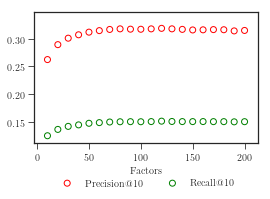

In [308]:
fig, ax = plt.subplots(figsize = (4, 3))
ax.scatter(factors_list, factors_precision, marker = "o", facecolor = "none", color = "red", label = "Precision@10")
ax.scatter(factors_list, factors_recall, marker = "o", facecolor = "none", color = "g", label = "Recall@10")
ax.set_xlabel("Factors")
#ax.grid(linestyle = "--")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.8])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
fig.savefig("factors.png", dpi = 1200)
plt.show()

#### Choice of `factors` :
We observe saturation of precision and recall and thus choose `factors` = 100.

#### Mean User-Average Precision@10 and Recall@10 vs Epochs :

In [207]:
alpha = 0.01
lmbda = 1
N = 10
factors = 100

epochs_list = [i for i in range(10, 205, 10)]
epochs_precision = []
epochs_recall = []
for i, epochs in enumerate(epochs_list) :
    print("\rEpochs {0} of {1}".format(i + 1, len(epochs_list)), end = "")
    model = trainModel(train_itemuser, factors, epochs, "linear", alpha, lmbda)
    pr, re = getMeanPrecisionRecall(model, all_sids, N, train, val, train_useritem)
    epochs_precision.append(pr)
    epochs_recall.append(re)

np.savetxt("epochs_precision.txt", np.column_stack((epochs_list, epochs_precision)))
np.savetxt("epochs_recall.txt", np.column_stack((epochs_list, epochs_recall)))    

Epochs 20 of 20

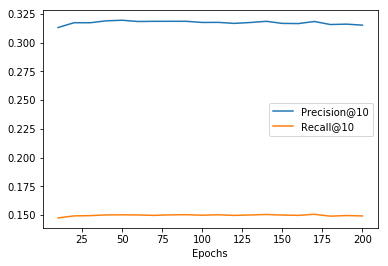

In [208]:
fig, ax = plt.subplots()
ax.plot(epochs_list, epochs_precision, label = "Precision@10")
ax.plot(epochs_list, epochs_recall, label = "Recall@10")
ax.set_xlabel("Epochs")
plt.legend()
plt.show()

#### Choice of Parameters :
The final set of parameters that we use is :
1. `factors` = 100
2. `epochs` = 50
3. `alpha` = 0.01
4. `lmbda` = 1

#### (Validation) Mean User-Average Precision@N and Recall@N for Optimal Choice of Parameters vs N :

In [211]:
factors = 100
epochs = 50
alpha = 0.01
lmbda = 1
model = trainModel(train_itemuser, factors, epochs, "linear", alpha, lmbda)

N_precision = []
N_recall = []

N_list = [i for i in range(5, 101, 5)]
for i, N in enumerate(N_list) :
    print("\rN {0} of {1}".format(i + 1, len(N_list)), end = "")
    pr, re = getMeanPrecisionRecall(model, all_sids, N, train, val, train_useritem)
    N_precision.append(pr)
    N_recall.append(re)
    
np.savetxt("N_precision.txt", np.column_stack((N_list, N_precision)))
np.savetxt("N_recall.txt", np.column_stack((N_list, N_recall)))   

N 20 of 20

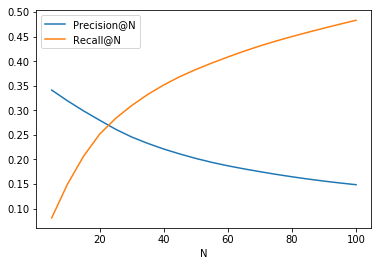

In [212]:
fig, ax = plt.subplots()
ax.plot(N_list, N_precision, label = "Precision@N")
ax.plot(N_list, N_recall, label = "Recall@N")
ax.set_xlabel("N")
plt.legend()
plt.show()

#### Game Similarity Observations :

#### Explanation for Recommendations :

#### Evaluating on Test Set :

In [263]:
"""factors = 100
epochs = 50
alpha = 0.01
lmbda = 1

df = pd.read_csv("data/final_data.csv", index_col = 0)
df_coded, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid = constructCodes(df)
all_sids = sid_to_steamid.keys()

rows = []
reps = 10

N_list = [i for i in range(5, 101, 5)]
for i, N in enumerate(N_list) :
    for j, r in enumerate(range(reps)) :
        train, val, test = getSplit(df_coded, train_size = 0.6, validation_size = 0.2)
        trainval_useritem, trainval_itemuser = constructSparseMatrices(val)
        model = trainModel(trainval_itemuser, factors, epochs, "linear", alpha, lmbda)
        pr, re = getMeanPrecisionRecall(model, all_sids, N, val, test, trainval_useritem)
        rows.append([N, r, pr, re])
        print("\rN = {0}, Rep = {1}, Precision = {2}, Recall = {3}".format(N, r + 1, pr, re))
test_df = pd.DataFrame(rows, columns = ["N", "rep", "precision", "recall"])
test_df.to_csv("test_results.csv")"""

'factors = 100\nepochs = 50\nalpha = 0.01\nlmbda = 1\n\ndf = pd.read_csv("data/final_data.csv", index_col = 0)\ndf_coded, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid = constructCodes(df)\nall_sids = sid_to_steamid.keys()\n\nrows = []\nreps = 10\n\nN_list = [i for i in range(5, 101, 5)]\nfor i, N in enumerate(N_list) :\n    for j, r in enumerate(range(reps)) :\n        train, val, test = getSplit(df_coded, train_size = 0.6, validation_size = 0.2)\n        trainval_useritem, trainval_itemuser = constructSparseMatrices(val)\n        model = trainModel(trainval_itemuser, factors, epochs, "linear", alpha, lmbda)\n        pr, re = getMeanPrecisionRecall(model, all_sids, N, val, test, trainval_useritem)\n        rows.append([N, r, pr, re])\n        print("\rN = {0}, Rep = {1}, Precision = {2}, Recall = {3}".format(N, r + 1, pr, re))\ntest_df = pd.DataFrame(rows, columns = ["N", "rep", "precision", "recall"])\ntest_df.to_csv("test_results.csv")'

In [228]:
temp = test_df[["N", "precision", "recall"]].groupby("N").mean()

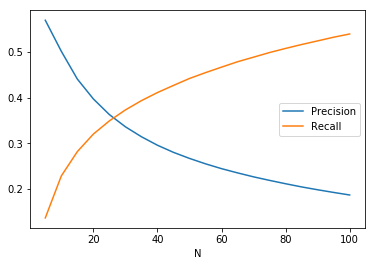

In [230]:
fig, ax = plt.subplots()
ax.plot(temp.index, temp["precision"], label = "Precision")
ax.plot(temp.index, temp["recall"], label = "Recall")
ax.set_xlabel("N")
plt.legend()
plt.show()

#### Log Confidence Function :

In [264]:
factors = 100
epochs = 50
alpha = 1
lmbda = 1
N = 10

df = pd.read_csv("data/final_data.csv", index_col = 0)
df_coded, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid = constructCodes(df)
all_sids = sid_to_steamid.keys()

train, val, test = getSplit(df_coded, train_size = 0.6, validation_size = 0.2)
trainval_useritem, trainval_itemuser = constructSparseMatrices(val)
model = trainModel(trainval_itemuser, factors, epochs, "log", alpha, lmbda)
pr, re = getMeanPrecisionRecall(model, all_sids, N, val, test, trainval_useritem)
print(pr, re)

/home/ieshan/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 50.0/50 [00:20<00:00,  2.47it/s]


0.5570458649331889 0.2557404304781588


In [34]:
def buildBaseline(by, train, test, k = 10) :
    """
    by = users, playtime
    """
    if by == "users" :
        top = train.groupby("aid").count().sort_values("sid", ascending = False).iloc[:k].index
    elif by == "playtime" :
        top = train.groupby("aid").sum().sort_values("playtime_forever", ascending = False).iloc[:k].index
    else :
        print("Wrong 'by'")
        return(None)
    precisions, recalls = [], []
    sids = test["sid"].unique()
    
    for sid in sids :
        masked_aid, full_aid = getMaskedAid(sid, train, test)
        precision = len(set(masked_aid) & set(top)) / k
        recall = len(set(masked_aid) & set(top)) / len(masked_aid)
        precisions.append(precision)
        recalls.append(recall)
    return(precisions, recalls)

In [26]:
df = pd.read_csv("data/final_data.csv", index_col = 0)
df_coded, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid = constructCodes(df)
train, val, test = getSplit(df_coded, train_size = 0.6, validation_size = 0.2)

/home/ieshan/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [39]:
precisions, recalls = buildBaseline("playtime", val, test)

In [40]:
np.mean(precisions)

0.09243048031780425

In [41]:
np.mean(recalls)

0.035237340825696316

In [37]:
np.mean(precisions)

0.10859516070783676

In [38]:
np.mean(recalls)

0.04677015599229069

In [15]:
df_coded.groupby("aid").count().sort_values("sid", ascending = False).iloc[:10].index

Int64Index([1840, 23, 21, 1763, 147, 22, 1579, 3762, 3750, 5536], dtype='int64', name='aid')

In [18]:
df_coded.groupby("aid").sum().sort_values("playtime_forever", ascending = False).iloc[:10].index

Int64Index([23, 147, 1985, 2944, 1763, 10316, 1310, 21, 1189, 0], dtype='int64', name='aid')

In [22]:
df_coded.groupby("sid")

In [81]:
sparsity = lambda x : 1 - len(x) / (x["sid"].nunique() * x["aid"].nunique())

In [82]:
def learningCurve(df, train_sizes, test_size, params, all_sids, reps = 10, k = 10) :
    precisions = {}
    recalls = {}
    for train_size in train_sizes :
        assert train_size + test_size <= 1
        pres = []
        recs = []
        spars = []
        if train_size + test_size == 1 :
            for rep in range(reps) :
                train, val, test = getSplit(df, 0.1, 1 - test_size - 0.1)
                spar = sparsity(test)
                print("\rTrain Size : {0}, Sparsity : {1}, Repetition : {2}".format(train_size, spar * 100, rep + 1), end = "")
                #Training == val
                factors, epochs, alpha, lmbda, conf_func = params["factors"], params["epochs"], params["alpha"], params["lmbda"], params["conf_func"]
                train_useritem, train_itemuser = constructSparseMatrices(val)
                model = trainModel(train_itemuser, factors, epochs, conf_func, alpha, lmbda)
                pr, re = getMeanPrecisionRecall(model, all_sids, k, val, test, train_useritem)
                spars.append(spar)
                pres.append(pr)
                recs.append(re)      
                
        else :
            for rep in range(reps) :
                val_size = test_size
                train, val, test = getSplit(df, train_size, val_size)
                spar = sparsity(val)
                print("\rTrain Size : {0}, Sparsity : {1}, Repetition : {2}".format(train_size, spar * 100, rep + 1), end = "")
                #Training = train
                factors, epochs, alpha, lmbda, conf_func = params["factors"], params["epochs"], params["alpha"], params["lmbda"], params["conf_func"]
                train_useritem, train_itemuser = constructSparseMatrices(train)
                model = trainModel(train_itemuser, factors, epochs, conf_func, alpha, lmbda)
                pr, re = getMeanPrecisionRecall(model, all_sids, k, train, val, train_useritem)
                spars.append(spar)
                pres.append(pr)
                recs.append(re)
        mean_spar = np.mean(spars)
        precisions[mean_spar] = pres
        recalls[mean_spar] = recs
    return(precisions, recalls)

In [83]:
df = pd.read_csv("data/final_data.csv", index_col = 0)
df_coded, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid = constructCodes(df)

train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
#train_sizes = [0.2, 0.4, 0.6, 0.8]
params = {"factors" : 100,
          "epochs" : 50,
          "alpha" : 0.01,
          "lmbda" : 1,
          "conf_func" : "linear"}

precisions, recalls = learningCurve(df_coded, train_sizes, 0.2, params, sid_to_steamid.keys(), reps = 10)

/home/ieshan/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train Size : 0.8, Sparsity : 98.16179292949946, Repetition : 10

In [84]:
precisions

{0.9944838782526284: [0.1159407728421813,
  0.11852654387865655,
  0.11794871794871795,
  0.11758757674250632,
  0.11819429396894186,
  0.11752979414951246,
  0.11778981581798484,
  0.11726254965691585,
  0.11694474539544962,
  0.1177392560491152],
 0.9926470125955438: [0.150588660166125,
  0.1493102202961358,
  0.1493752257132539,
  0.15007583965330445,
  0.15020585048754062,
  0.14972192127121708,
  0.15060310581437344,
  0.1484001444564825,
  0.15014084507042255,
  0.1501047309498014],
 0.9907897236271083: [0.18301191765980498,
  0.18191404839292166,
  0.18364030335861323,
  0.18302636330805347,
  0.18264355362946913,
  0.18074395088479592,
  0.18319971108703503,
  0.18257854821235103,
  0.1818779342723005,
  0.18336583604189235],
 0.9889709000082844: [0.21763813651137592,
  0.22049115204044784,
  0.21800650054171183,
  0.21719032141567352,
  0.21890213073311662,
  0.22123510292524376,
  0.21612856626941135,
  0.21721921271217046,
  0.21760924521487904,
  0.21905381003972554],
 0.98

In [85]:
recalls

{0.9944838782526284: [0.0561786045699461,
  0.05776708539581579,
  0.05711400099889777,
  0.05703752960114014,
  0.057560969975371606,
  0.05680438383736715,
  0.0569700967876166,
  0.05610466529272793,
  0.05715434363443922,
  0.05733984366979723],
 0.9926470125955438: [0.07176267770442754,
  0.07142588306564944,
  0.07059508960934115,
  0.07181619139365039,
  0.07159398697985647,
  0.07113875268787993,
  0.07164241256708459,
  0.06992009703370058,
  0.07213903034372512,
  0.07167704958496263],
 0.9907897236271083: [0.08620227670126393,
  0.0864494281006333,
  0.08680541005453908,
  0.0868369951428297,
  0.08716866311272681,
  0.08530520089104404,
  0.08698989461563854,
  0.08695584129201035,
  0.08664231496015096,
  0.08686394035853848],
 0.9889709000082844: [0.10341761789410946,
  0.10468262546697223,
  0.10340396676395534,
  0.10362802352200509,
  0.10341077441236408,
  0.10475028893922221,
  0.10227624466157924,
  0.10376791442968455,
  0.1026288872582176,
  0.10401508164462825],


In [99]:
df_prec = []
for key, value in precisions.items() :
    df_prec.append([key] + value)
precision_df = pd.DataFrame(df_prec, columns = ["Sparsity"] + ["Run " + str(i) for i in range(1, len(df_prec[0]))])

In [100]:
df_rec = []
for key, value in recalls.items() :
    df_rec.append([key] + value)
recall_df = pd.DataFrame(df_rec, columns = ["Sparsity"] + ["Run " + str(i) for i in range(1, len(df_prec[0]))])

In [103]:
precision_df.to_csv("learningcurve_precision.csv")
recall_df.to_csv("learningcurve_recall.csv")

In [108]:
mean_precision = precision_df.set_index("Sparsity").mean(axis = 1)
mean_recall = recall_df.set_index("Sparsity").mean(axis = 1)

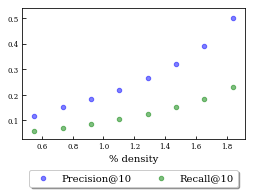

In [120]:
fig, ax = plt.subplots(figsize = (4, 3))
ax.scatter(100 * (1 - mean_precision.index), mean_precision.values, marker = "o", alpha = 0.5, s = 20, color = "blue", label = "Precision@10")
ax.scatter(100 * (1 - mean_recall.index), mean_recall.values, marker = "o", alpha = 0.5, s = 20, color = "g", label = "Recall@10")
ax.set_xlabel("% density")
ax.tick_params(direction = "in")
#ax.grid(linestyle = "--")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.8])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
#ax.set_xticks([0, 25, 50, 75, 100, 125, 150, 175, 200])
#ax.set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
#fig.savefig("temp.svg")
plt.show()

In [125]:
df_coded["aid"].nunique()

12982

In [128]:
factors = 100
epochs = 50
alpha = 1
lmbda = 1

df = pd.read_csv("data/final_data.csv", index_col = 0)
df_coded, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid = constructCodes(df)
all_sids = sid_to_steamid.keys()

rows = []
reps = 10

N_list = [i for i in range(5, 101, 5)]
for i, N in enumerate(N_list) :
    for j, r in enumerate(range(reps)) :
        train, val, test = getSplit(df_coded, train_size = 0.6, validation_size = 0.2)
        trainval_useritem, trainval_itemuser = constructSparseMatrices(val)
        model = trainModel(trainval_itemuser, factors, epochs, "log", alpha, lmbda)
        pr, re = getMeanPrecisionRecall(model, all_sids, N, val, test, trainval_useritem)
        rows.append([N, r, pr, re])
        print("\rN = {0}, Rep = {1}, Precision = {2}, Recall = {3}".format(N, r + 1, pr, re))
test_df = pd.DataFrame(rows, columns = ["N", "rep", "precision", "recall"])
test_df.to_csv("log_test_results.csv")

/home/ieshan/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


N = 5, Rep = 1, Precision = 0.6323293607800652, Recall = 0.15156535855068362
N = 5, Rep = 2, Precision = 0.6369808595160708, Recall = 0.1527459924213601
N = 5, Rep = 3, Precision = 0.6353051643192488, Recall = 0.1520575544785478
N = 5, Rep = 4, Precision = 0.6360852293246659, Recall = 0.1526510022892756
N = 5, Rep = 5, Precision = 0.6365763813651139, Recall = 0.1528922044897404
N = 5, Rep = 6, Precision = 0.6339039364391477, Recall = 0.1523446022739225
N = 5, Rep = 7, Precision = 0.6340195016251354, Recall = 0.15219239421047287
N = 5, Rep = 8, Precision = 0.6370386421090646, Recall = 0.1529394214146356
N = 5, Rep = 9, Precision = 0.6321560130010835, Recall = 0.15179550891750176
N = 5, Rep = 10, Precision = 0.6326182737450342, Recall = 0.15177368385922885
N = 10, Rep = 1, Precision = 0.558013723365836, Recall = 0.2561181869765461
N = 10, Rep = 2, Precision = 0.5581437342000722, Recall = 0.25611015974074164
N = 10, Rep = 3, Precision = 0.55882267966775, Recall = 0.2564969843133885
N = 10

In [129]:
factors = 100
epochs = 50
alpha = 1
lmbda = 1

df = pd.read_csv("data/final_data.csv", index_col = 0)
df_coded, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid = constructCodes(df)
train, val, test = getSplit(df_coded, 0.6, 0.2)
trainval_useritem, trainval_itemuser = constructSparseMatrices(val)
model = trainModel(trainval_itemuser, factors, epochs, "log", alpha, lmbda)

/home/ieshan/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [137]:
appid_to_aid[105600]

1310

In [138]:
nfs_sim = model.similar_items(1310)
for item in nfs_sim :
    aid = item[0]
    appid = aid_to_appid[aid]
    print(appid)

105600
620
4000
550
49520
218620
230410
730
72850
211820


In [130]:
#Games similar to CS :
cs_sim = model.similar_items(0)
for item in cs_sim :
    aid = item[0]
    appid = aid_to_appid[aid]
    print(appid)

10
80
100
240
30
60
40
300
282660
70


In [136]:
#Games similar to Skyrim :
skyrim_sim = model.similar_items(8545)
for item in skyrim_sim :
    aid = item[0]
    appid = aid_to_appid[aid]
    print(appid)

489830
377160
365720
72850
22370
292030
306130
22380
22330
241930
